In [1]:
%load_ext autoreload
%autoreload 2

In [435]:
import os
import geopandas as gpd
import pandas as pd
import scipy
from shapely.geometry import shape
from dateutil import parser
from datetime import timedelta
import pickle
import missingno as msno
import matplotlib.pyplot as plt

import data_preprocess as prep
import data_explore as exp
import pipeline as pp

pd.options.display.max_columns = 999

In [107]:
SDT = "LICENSE TERM START DATE"
EDT = 'LICENSE TERM EXPIRATION DATE'
IDT = 'DATE ISSUED'

**All functions defined in this notebook are dataset specific and should go into a file `data_preprocessing.py` to import into pipeline**

# Load

If you are loading license data for the first time

In [7]:
##### LOAD LICENSE DATA FOR THE FIRST TIME
# make sure these column aren't numerical
lcs_dtype = {
    'LICENSE ID': str,
    'ACCOUNT NUMBER': str,
    'WARD': str,
    'PRECINCT': str,
    'POLICE DISTRICT': str,
    'LICENSE CODE': str,
    'LICENSE NUMBER': str,
    'SSA': str
}

# date columns to parse
lcs_dates = [
    'APPLICATION CREATED DATE', 
    'APPLICATION REQUIREMENTS COMPLETE', 
    'PAYMENT DATE',
    'LICENSE TERM START DATE',
    'LICENSE TERM EXPIRATION DATE',
    'LICENSE APPROVED FOR ISSUANCE',
    'DATE ISSUED',
    'LICENSE STATUS CHANGE DATE'
]
# load from csv
lcs = pd.read_csv('data/Business_Licenses.csv', dtype=lcs_dtype, parse_dates=lcs_dates)

/usr/local/anaconda3/envs/mlpp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
def gdf_from_latlong(df, lat, long):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[long], df[lat]))
    return gdf

In [18]:
lcs = gdf_from_latlong(lcs, lat='LATITUDE', long='LONGITUDE')

In [19]:
# save licenses gdf for later 
pickle.dump(lcs, open("pickle/lcs", "wb" ))

If you have loaded and pickled the data before

In [176]:
##### LOAD LICENSE DATA SUBSEQEUNTLY
lcs_raw = pickle.load(open("pickle/lcs", "rb" ))

In [178]:
len(lcs_raw)

968908

In [179]:
lcs_raw.dtypes

ID                                           object
LICENSE ID                                   object
ACCOUNT NUMBER                               object
SITE NUMBER                                   int64
LEGAL NAME                                   object
DOING BUSINESS AS NAME                       object
ADDRESS                                      object
CITY                                         object
STATE                                        object
ZIP CODE                                     object
WARD                                         object
PRECINCT                                     object
WARD PRECINCT                                object
POLICE DISTRICT                              object
LICENSE CODE                                 object
LICENSE DESCRIPTION                          object
BUSINESS ACTIVITY ID                         object
BUSINESS ACTIVITY                            object
LICENSE NUMBER                               object
APPLICATION 

########
Number and percentage of missing data in each column:



,num_NA,perc_NA
LEGAL NAME,4,0.000004
DOING BUSINESS AS NAME,60,0.000062
CITY,5,0.000005
STATE,12,0.000012
ZIP CODE,413,0.000426
WARD,71402,0.073693
PRECINCT,101259,0.104508
WARD PRECINCT,71229,0.073515
POLICE DISTRICT,95892,0.098969
BUSINESS ACTIVITY ID,531476,0.548531


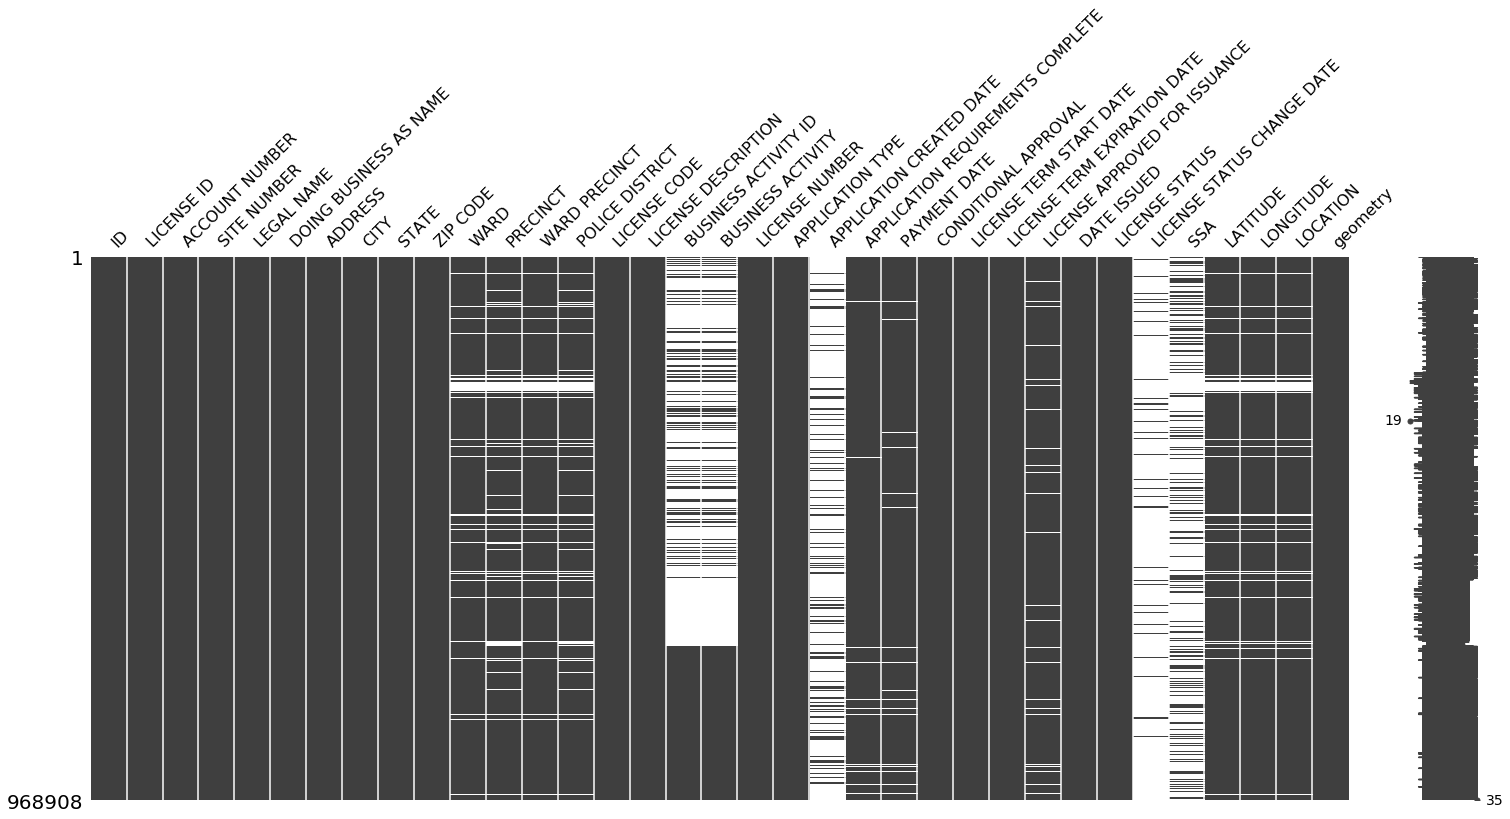

In [117]:
# Missing
exp.summarize_missing(lcs_raw)

basic cleaning:

In [249]:
lcs = lcs_raw.copy()

In [250]:
# add business id: account_number-site_number
lcs['business_id'] = lcs['ACCOUNT NUMBER'] + "-" + lcs['SITE NUMBER'].map(str)

In [251]:
# start date NA rows - mostly ISSUE
lcs_raw[lcs_raw[SDT].isna()].groupby('APPLICATION TYPE').size()

APPLICATION TYPE
C_CAPA      25
C_EXPA      10
C_LOC       58
C_SBA        4
ISSUE     2403
RENEW      182
dtype: int64

In [252]:
# No start date, issuance: start date = issue date
nastart_issue = lcs[SDT].isna() & (lcs['APPLICATION TYPE'] == 'ISSUE')
lcs.loc[nastart_issue, SDT] = lcs.loc[nastart_issue, IDT]

In [253]:
# No start date, other: drop
lcs = lcs.dropna(subset=[SDT])

In [254]:
# drop rows with negative license length (5a310 rows)
lcs = lcs[(lcs[EDT] - lcs[SDT]) > timedelta(days=0)]

In [255]:
# total num of rows dropped
len(lcs_raw) - len(lcs)

3752

In [430]:
# Do we map neighborhoods? If so, we have to drop this many rows b/c they don't have lat longs
len(lcs[lcs.geometry.isna()])

73944

In [424]:
def add_zillow_nbh_id(gdf, nbh_filepath):
    '''
    Add neighborhood ID (Zillow) 

    Input:
        gdf: (GeoDataFrame) 
        nbh_filepath: (str) filename of the zillow region shp file  
    Returns: (GeoDataFrame)
    '''
    nbh = gpd.read_file(nbh_filepath)
    nbh.crs = {'init': 'epsg:4326'}
    gdf.crs = {'init': 'epsg:4326'}

    joined = gpd.sjoin(gdf, nbh, how="left", op='intersects')
    # drop unmatches and extra columns
    joined.dropna(axis=0, subset=["index_right"], inplace=True)
    joined.drop('index_right', axis=1, inplace=True)
    
    return joined

In [256]:
# sort data by license start date
lcs.sort_values(by=SDT, inplace=True)

In [257]:
lcs.head()

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,LICENSE CODE,LICENSE DESCRIPTION,BUSINESS ACTIVITY ID,BUSINESS ACTIVITY,LICENSE NUMBER,APPLICATION TYPE,APPLICATION CREATED DATE,APPLICATION REQUIREMENTS COMPLETE,PAYMENT DATE,CONDITIONAL APPROVAL,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION,geometry,business_id
349021,38186-19950216,177127,15572,1,ANTHONY & SANDRA BALLENGER,ROCK ANTHONY'S BEAUTY SUPPLY,5359 W MADISON ST,CHICAGO,IL,60644,29,10,29-10,15,1010,Limited Business License,NaN,NaN,38186,ISSUE,NaT,2000-06-20,NaT,N,1995-02-16,1996-02-15,2003-12-22,2006-04-12,AAI,NaT,NaN,41.880203,-87.759784,"(41.88020253400151, -87.75978400378037)",POINT (-87.759784004 41.880202534),15572-1
135168,31386-19950216,145611,31848,1,GALGANO RECORDS,GALGANO RECORDS,2015 W IRVING PARK RD,CHICAGO,IL,60618,47,29,47-29,19,1010,Limited Business License,NaN,NaN,31386,ISSUE,NaT,2000-06-20,NaT,N,1995-02-16,1996-02-15,2003-12-22,2006-04-12,AAI,NaT,38,41.954036,-87.679506,"(41.95403596563116, -87.6795064784822)",POINT (-87.67950647799999 41.954035966),31848-1
680943,37719-19950216,174995,15469,1,UNIVERSAL AUTOMOTIVE INC,UNIVERSAL AUTOMOTIVE INC,2542 S WESTERN AVE 1ST,CHICAGO,IL,60608,25,5,25-5,10,1010,Limited Business License,NaN,NaN,37719,ISSUE,NaT,2000-06-20,NaT,N,1995-02-16,1996-02-15,2003-12-22,2006-04-12,AAI,NaT,NaN,41.845358,-87.685608,"(41.845357760799374, -87.68560845692359)",POINT (-87.685608457 41.845357761),15469-1
194572,24896-19950216,115610,30163,1,SERBIA TOURS INC,SERBIA TOURS INC,4056 W LAWRENCE AVE 1ST,CHICAGO,IL,60630,39,8,39-8,17,1133,Broker,NaN,NaN,24896,ISSUE,NaT,2000-06-20,NaT,N,1995-02-16,1996-02-15,2003-12-22,2006-04-12,AAI,NaT,NaN,41.968327,-87.730341,"(41.96832692907906, -87.7303413599419)",POINT (-87.73034136 41.968326929),30163-1
527063,33736-19950216,156504,32448,1,CONSUMER MORTAGE OF AMERICA IN,CONSUMER MORTGAGE OF AMERICA,2804 W BELMONT AVE,CHICAGO,IL,60618,33,2,33-2,17,1010,Limited Business License,NaN,NaN,33736,ISSUE,NaT,2000-06-20,NaT,N,1995-02-16,1996-02-15,2003-12-22,2006-04-12,AAI,NaT,NaN,41.939501,-87.698149,"(41.93950090239686, -87.6981489851435)",POINT (-87.698148985 41.939500902),32448-1


# Link data

to be done together

# Train test split

In [258]:
pipeline = pp.Pipeline()
pipeline.load_clean_data(lcs)

In [259]:
start = parser.parse('1995-02-16') # earliest lic start date in original data
end = parser.parse('2020-07-16') # latest lic start date in original data
pipeline.get_train_test_times(start, end, 2, 2)

for i, (train_start, train_end, test_start, test_end) in enumerate(pipeline.train_test_times):
    print('N = {}'.format(i))
    print('TRAIN: START {} END {}'.format(train_start, train_end))
    print('TEST: START {} END {}\n'.format(test_start, test_end))

N = 0
TRAIN: START 1995-02-16 00:00:00 END 1997-02-15 00:00:00
TEST: START 1999-02-16 00:00:00 END 2001-02-15 00:00:00

N = 1
TRAIN: START 1995-02-16 00:00:00 END 1999-02-15 00:00:00
TEST: START 2001-02-16 00:00:00 END 2003-02-15 00:00:00

N = 2
TRAIN: START 1995-02-16 00:00:00 END 2001-02-15 00:00:00
TEST: START 2003-02-16 00:00:00 END 2005-02-15 00:00:00

N = 3
TRAIN: START 1995-02-16 00:00:00 END 2003-02-15 00:00:00
TEST: START 2005-02-16 00:00:00 END 2007-02-15 00:00:00

N = 4
TRAIN: START 1995-02-16 00:00:00 END 2005-02-15 00:00:00
TEST: START 2007-02-16 00:00:00 END 2009-02-15 00:00:00

N = 5
TRAIN: START 1995-02-16 00:00:00 END 2007-02-15 00:00:00
TEST: START 2009-02-16 00:00:00 END 2011-02-15 00:00:00

N = 6
TRAIN: START 1995-02-16 00:00:00 END 2009-02-15 00:00:00
TEST: START 2011-02-16 00:00:00 END 2013-02-15 00:00:00

N = 7
TRAIN: START 1995-02-16 00:00:00 END 2011-02-15 00:00:00
TEST: START 2013-02-16 00:00:00 END 2015-02-15 00:00:00

N = 8
TRAIN: START 1995-02-16 00:00:00 E

# For 1 Split: (example)

In [407]:
# example
time_col = SDT
train_start, train_end, test_start, test_end = pipeline.train_test_times[3]

In [408]:
train_df = lcs[(lcs[time_col] >= train_start) & (lcs[time_col] <= train_end)]
test_df = lcs[(lcs[time_col] >= test_start) & (lcs[time_col] <= test_end)]

## Before generating outcome: get latest license and other info

For each business:
1. Identify if business has applied for special type licenses in the 2-year period
2. Get the total number of licenses applied 
3. Get the latest license (latest start date)

In [406]:
def get_special_apptypes_by_business(df):
    '''get dummies for whether business has applied for non-issuance/renewal licenses
    within the period'''
    app_type_dummies = pd.get_dummies(df['APPLICATION TYPE'], prefix='applied_for_type')
    other_app_type_dummies = app_type_dummies[['applied_for_type_C_CAPA', 
                                               'applied_for_type_C_EXPA',
                                               'applied_for_type_C_LOC']]
    temp = pd.concat([df, other_app_type_dummies], axis=1)
    other_type_by_bus = temp.groupby('business_id').agg(
                                    {'applied_for_type_C_CAPA': 'sum', 
                                     'applied_for_type_C_EXPA': 'sum',
                                     'applied_for_type_C_LOC': 'sum'}).reset_index()
    return other_type_by_bus

In [381]:
def get_num_licenses_applied(df):
    return df.groupby('business_id').size().reset_index().rename(columns={0: 'num_licenses'})

In [382]:
def get_latest_license(df):
    other_type_by_bus = get_special_apptypes_by_business(df)
    num_licenses = get_num_licenses_applied(df)
    latest = df[df['APPLICATION TYPE'].isin(['RENEW','ISSUE'])] \
               .groupby('business_id') \
               .tail(1) \
               .merge(other_type_by_bus, on='business_id') \
               .merge(num_licenses, on='business_id')
    return latest

In [409]:
# get latest renew/issue license for each business
train_latest = get_latest_license(train_df)
test_latest = get_latest_license(test_df)

## Generate outcome

In [385]:
def generate_label(latest, set_end):
    # initialize outcome column
    latest.loc[:,'closed'] = 0
    # label = 1 if latest license expires before our training end date
    # we are assuming a business is continuing to exist if the latest license expires 
    # on our train/test end date
    latest.loc[latest[EDT] < set_end, 'closed'] = 1    
    # label = 1 if latest license expires after train/test end date but are not approved
    latest.loc[(latest[EDT] >= set_end) & (latest['LICENSE STATUS'] != 'AAI'), 'closed'] = 1

In [410]:
# generate label
generate_label(train_latest, train_end)
generate_label(test_latest, test_end)

In [411]:
train_latest.groupby('closed').size()

closed
0    56221
1     6081
dtype: int64

In [412]:
test_latest.groupby('closed').size()

closed
0    57078
1    14674
dtype: int64

## Get X_train, y_train, X_test, y_test

In [390]:
def split_Xy(train, test, predictor_cols, label):
    X_train = train[predictor_cols]
    y_train = train[label]
    X_test = test[predictor_cols]
    y_test = test[label]
    return X_train, y_train, X_test, y_test

In [416]:
label = 'closed'
predictor_cols = ['ZIP CODE', 'WARD', 'PRECINCT', 'WARD PRECINCT', 
                  'POLICE DISTRICT', 'LICENSE CODE', 'BUSINESS ACTIVITY ID',
                  'APPLICATION TYPE', 'APPLICATION CREATED DATE', 
                  'APPLICATION REQUIREMENTS COMPLETE', 
                  'PAYMENT DATE', 'CONDITIONAL APPROVAL', 
                  'LICENSE TERM START DATE', 'LICENSE TERM EXPIRATION DATE', 
                  'LICENSE APPROVED FOR ISSUANCE', 'DATE ISSUED', 
                  'LICENSE STATUS', 'LICENSE STATUS CHANGE DATE', 
                  'SSA', 'LATITUDE', 'LONGITUDE', 'geometry', 'applied_for_type_C_CAPA', 
                  'applied_for_type_C_EXPA', 'applied_for_type_C_LOC', 'num_licenses']

In [417]:
X_train, y_train, X_test, y_test = split_Xy(train_latest, test_latest, predictor_cols, label)

# Feature Engineering

### 1. Application type
no change

### 2. **Business Activity

1. Impute using mode based on license type? 
2. One row could have multiple values -> special split

#### Imputation

In [452]:
X_train.groupby('APPLICATION TYPE')['BUSINESS ACTIVITY ID'].apply(lambda x: x.value_counts())

APPLICATION TYPE     
ISSUE             775    1072
                  763     295
                  720     119
                  638      48
                  864      45
                  624      41
                  725      38
                  704      28
                  726      23
                  653      23
                  774      22
                  666      20
                  743      18
                  829       8
                  853       8
                  630       7
                  865       4
                  732       3
                  784       3
                  868       2
                  629       2
                  785       1
                  644       1
                  794       1
RENEW             775    5551
                  638    1488
                  829    1227
                  763     965
                  774     948
                  864     735
                  725     452
                  666     132
                  

In [431]:
# fill NA with mode ~ license
X_train['BUSINESS ACTIVITY ID'].fillna(X_train.groupby('APPLICATION TYPE').agg('mode'))

ValueError: mode is an unknown string function

#### Splitting - special split b/c of multi-values for one row

In [94]:
# special split
ba_ids = X_train['BUSINESS ACTIVITY ID'].str.get_dummies(sep=' | ').iloc[:,:-1]

In [149]:
all_ba_ids = ba_ids.sum().sort_values(ascending=False).apply(lambda x: x/len(lcs)).to_frame()
top_ba_ids = all_ba_ids[all_ba_ids[0] > 0.005].index

In [151]:
# # take top 30% 
# pct_sum = 0
# top_ba_ids = []
# for i, row in ba_ids.iterrows():
#     if row[0] + pct_sum > 0.3:
#         break
#     pct_sum += row[0]
#     top_ba_ids.append(i)

In [163]:
lcs[lcs['BUSINESS ACTIVITY ID'].isin(top_ba_ids)]['BUSINESS ACTIVITY'].value_counts()

Retail Sales of Perishable Foods                                             126987
Retail Sale of Tobacco                                                        39775
Consumption of Liquor on Premises                                             29839
Tavern - Consumption of Liquor on Premise                                     16557
Retail Sales of Packaged Liquor                                               13843
Special Event Food                                                             8838
Wholesale Food Sales                                                           8690
Home Repair Services                                                           7734
Other Home Occupations                                                         7362
Not-For-Profit Selling Raffles for Prizes of $50 or More                       6617
Provide Parking Spaces For a Fee - Available and Advertised to the Public      6377
Provides Onsite Amusement or Entertainment                                  

### 3. License Type

In [166]:
# kept license types w/ > 1% counts
all_license_codes = lcs['LICENSE CODE'].value_counts(normalize=True).to_frame()
top_license_codes = all_license_codes[all_license_codes['LICENSE CODE'] > 0.01].index
prep.keep_top_values(lcs, 'LICENSE CODE', top_license_codes)

### 4. Number of Open Business in Locale (count of bus w/in two year periods)